In [ ]:
!nvidia-smi

# EYE GAZE SHARED TASK

In [ ]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

### IMPORT TRANSFORMERS

In [ ]:
#@title
#from transformers import BertTokenizer, BertForTokenClassification, BertModel
#from transformers import AlbertTokenizer, AlbertModel
#from transformers import ElectraForTokenClassification, ElectraTokenizer
from transformers import RobertaForTokenClassification, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base", add_prefix_space = True)
base_model = RobertaForTokenClassification.from_pretrained("roberta-base")

#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#base_model = BertForTokenClassification.from_pretrained("bert-base-uncased")
#base_model = BertModel.from_pretrained("bert-base-uncased")

#tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")
#base_model = ElectraForTokenClassification.from_pretrained("google/electra-small-discriminator")

### DOWNLOAD DATA

In [ ]:
train_data_file_path = "/content/drive/My Drive/CMCL Shared Task/training_data.csv"
#file_path = "/content/drive/MyDrive/datasets/EyeGazeSharedTask/trial_data.csv"

train_data = pd.read_csv(train_data_file_path)

In [ ]:
print("Train Data Shape = ", train_data.shape)
train_data

### BASIC MODEL PLAN

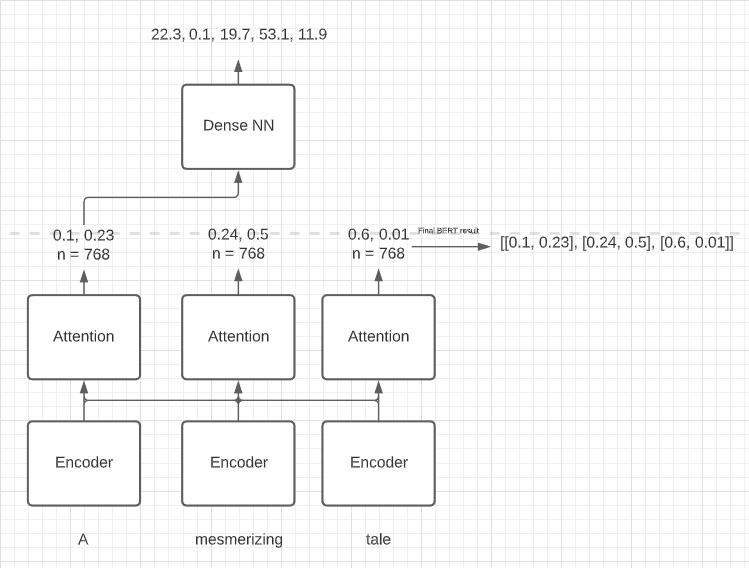

Steps:-

1. Form Sentences using (Sentence_id, Word_id). This creates 100 sentences of varying lengths.
2. Pad the sentences to the maximum sentence length.
3. Pass the sentence to a BERT model without the final Bert Pooler Layer. This creates a tensor of _(Batch_size, seq_length, hidden_size)_
4. Pass the final tensor to a Dense Neural Network where the final output should be _(Batch_size, Seq_length, 5)_.
5. Compare the output to the 5 target variables for each word and calculate loss.
6. Use backprop for gradient descent.

### IMPORT TOKENIZERS


























































### PREPROCESS DATA

#### REMOVE EOS TOKEN

In [ ]:
#@title
# FUNCTION TO REMOVE THE <EOS> TOKEN IN THE DATASET

def remove_eos(df):
  cnt = 1
  for i in range(df.shape[0]-1):
    if (df.loc[i+1, "sentence_id"] == cnt):
      df.loc[i, "word"] = df.loc[i, "word"][:-5]   # Remove <EOS> for the last word of each sentence.
      cnt += 1 
  s = df.loc[df.shape[0] - 1, "word"]              # Remove <EOS> for last element separately
  df.loc[df.shape[0] - 1, "word"] = s[:-6] 
  return df

### COUNT NO OF TOKENS FOR EACH WORD

In [ ]:
#@title
# FUNCTION TO CALCULATE NO OF TOKENS CREATED BY TOKENIZER PER WORD
# ADDS THE DATA IN A NEW COLUMN

def add_token_per_words(df):
  n_tokens_per_word = []
  cdf = 0
  cf_n_token_per_word = []
  for i, word in enumerate(df.word):
    n_tokens_per_word.append(len(tokenizer.encode(word)) - 2)
    if (i > 0) and (df.loc[i-1, "sentence_id"] != df.loc[i, "sentence_id"]):
      cdf = 0
    cdf += len(tokenizer.encode(word)) - 2
    cf_n_token_per_word.append(cdf)
  df["n_tokens"] = n_tokens_per_word
  df["cf_n_tokens"] = cf_n_token_per_word
  return df

### NO OF CHARS FOR EACH WORD

In [ ]:
#@title
# FUNCTION TO CALCULATE THE NUMBER OF CHARACTERS PER WORD
# ADDS THE DATA IN A NEW COLUMN

def char_per_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)))
  df["n_chars"] = n_chars
  return df

### NO OF CHARS OF WORD - LEMMATIZED WORD

In [ ]:
#@title
# FUNCTION TO CALCULATE THE DIFFERENCE BETWEEN NUMBER OF CHARACTERS IN WORD AND LEMMATIZED WORD
# ADDS AS A NEW COLUMN

from nltk import WordNetLemmatizer

Lemmatizer = WordNetLemmatizer()

def char_per_lemmatized_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)) - len(Lemmatizer.lemmatize(word)))
  df["n_char_lemmatized"] = n_chars
  return df

### STOP WORD OR NOT

In [ ]:
#@title
import nltk
nltk.download("stopwords")
nltk.download("wordnet")

stopwords = nltk.corpus.stopwords
stop_words = stopwords.words("english")

In [ ]:
#@title
# FUNCTION TO ASSERT WHETHER A WORD IS STOPWORD  OR NOT
# ADDS THE DATA IN A NEW COLUMN

def add_stopword_check(df):
  if_stopword = []
  for word in df.word:
    if_stopword.append(int(word in stop_words))

  df["stopword"] = if_stopword
  return df

### NUMBER OR NOT

In [ ]:
# FUNCTION TO DEFINE WHETHER IT IS A NUMBER OR NOT
# ADDS THE DATA AS A NEW COLUMN

def add_number_check(df):
  if_number = []
  for word in df.word:
    if_number.append(int(word.isdigit()))

  df["number"] = if_number
  return df

### TF IDF CALCULATION

In [ ]:
# FUNCTION TO CALCULATE THE TFIDF OF THE TRAINING DATASET
# ADDS THE DATA IN A NEW COLUMN
# ALSO RETURNS A LIST OF THE SENTENCES

import re
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=None)
bad_words = []
punc = string.punctuation

def remove_punc(word):
  table = str.maketrans('', '', punc)
  return word.translate(table)

def calc_tfidf(df):
  n = np.array(df["sentence_id"])[-1]
  sentences = []
  tf_idfs = []
  for i in range(n+1):   
    temp_df = df[df.sentence_id == i]
    sentence = (' ').join(np.array(temp_df.word))
    sentences.append(sentence)
  tf_idf = vectorizer.fit_transform(sentences)
  for i, word in enumerate(df.word):
    try:
      tf_idfs.append(tf_idf.toarray()[df["sentence_id"][i]][vectorizer.get_feature_names().index(remove_punc(word.lower()))])
    except:
      bad_words.append(word)
      if word in ["a", "A"]:
        tf_idfs.append(0.8)
      else:
        tf_idfs.append(0.01)
  df["tf_idf"] = tf_idfs

  return sentences, df, bad_words

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize 
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse = False)

def pos_tag_func(df):
  tags = []
  for word in df.word:
    if word not in string.punctuation:
      tag = nltk.pos_tag(word)[0][1]
    else:
      tag = "PUNC"
    tags.append(tag)
  df["tags"] = tags
  tag_transform = pd.DataFrame(enc.fit_transform(np.array(df.tags).reshape(-1, 1)))
  df = pd.concat((df, tag_transform), axis = 1)
  return df

In [ ]:
def use_transformed_GPT(df):
  df["GPT"] = df["TRT"] - df["GPT"]
  return df

In [ ]:
# FUNCTION TO PERFORM ALL PREPROCESSING STEPS

def preprocess(df):
  return calc_tfidf(use_transformed_GPT(pos_tag_func(add_number_check(add_stopword_check(char_per_lemmatized_word(char_per_word(add_token_per_words(remove_eos(df)))))))))

sentences, df, bad_words = preprocess(train_data)

df1 = df.copy()
df1

In [ ]:
print("No of words unaccounted for = ", len(bad_words))

In [ ]:
# FUNCTION TO NORMALISE ALL THE TARGET VALUES

from sklearn.preprocessing import normalize

def normalize_target(df):
  keys = df.keys()[3:8]
  new_df = pd.DataFrame(normalize(df.iloc[:,3:8], axis = 0, copy = True), columns = keys)
  df.update(new_df)
  return 
#normalize_target(df)

In [ ]:
#!pip install ner-d

In [ ]:
'''
from nerd import ner

sample_sentence = "America"
sample = ner.name(sample_sentence)
text_label = [(x.text, x.label_) for x in sample]
print(text_label)
'''

In [ ]:
'''
def form_sentences(df):
  n = np.array(df["sentence_id"])[-1]
  sentences = []
  max_len = 0
  for i in range(n+1):   
    temp_df = df[df.sentence_id == i]
    sentence = (' ').join(np.array(temp_df.word))
    sentences.append([sentence])
    max_len = max(max_len, len(sentence))

  return sentences, max_len

sentences, max_len = form_sentences(df_temp)
print(f"No of Sentences {len(sentences)} and Max Sentence Length = {max_len} ")
sentences[4]
'''

### FORM TARGETS

In [ ]:
# FUNCTION TO FORM TARGETS AND OTHER FEATURES IN SEPARATE DATA STRUCTURES

from sklearn.preprocessing import normalize

def form_targets(df):
  n = np.array(df["sentence_id"])[-1]
  targets = []
  cdfs = []
  tags = []
  features = {"n_chars" : [],
              "stopword" : [],
              "number" : [],
              "n_char_lemmatized" : [],
              "tf_idf" : [],
              }

  for i in range(n+1):
    temp_df = df[df.sentence_id == i]
    for key in features.keys():
      features[key].append(np.array(temp_df.loc[:, key]))
    targets.append(np.array(temp_df.iloc[:, 3:8]))
    cdfs.append(np.array(temp_df.loc[:, "cf_n_tokens"]))
    tags.append(np.array(temp_df.iloc[:, -20:]))
  return targets, cdfs, features, tags

targets, cdfs, features, tags = form_targets(df)
print("Target Shape = ", np.array(targets, dtype = "object").shape)
print("Cumulative Freq Label shape = ",np.array(cdfs, dtype = "object").shape)

### IMPORT TOKENIZERS AND MODELS

In [ ]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


### FORMING CLASS OF DATA

In [ ]:
# Class for the data
# Contains 4 keys -> Sentences, targets, input_ids(for BERT), attention_mask(for BERT) 

class EyeGaze_dataset(Dataset):
  def __init__(self, sentencess, targets, cdfs, features, tags, tokenizer):
    self.sentences = sentences               # List of Sentences
    self.targets = targets                   # List of Padded Targets
    self.tokenizer = tokenizer               # Tokenizer to be used (BERT)
    self.cdfs = cdfs                         # Cumulative Frequency Function
    self.features = features
    self.tags = tags
    
  def __len__(self):
    return len(self.sentences)               # No of Examples = 100

  def __getitem__(self, index):
    sentence = str(self.sentences[index])        # Get the review at the particular index
    target = self.targets[index]                    # Get the target label at the particular index
    cdf = self.cdfs[index]
    feature = {}
    for key in features.keys():
      feature[key] = features[key][index]
    tag = tags[index]
    encoding = self.tokenizer.encode_plus(   # Encoder encoding the particular review
        sentence,
        return_attention_mask = True,
        return_tensors = "pt"
    )
    # The class simply returns a dictionary of the following
    return_dict = {"sentence" : sentence,
                   "target":torch.tensor(target, dtype = torch.float32),
                   "input_ids":encoding["input_ids"].flatten(),
                   "attention_mask":encoding["attention_mask"].flatten(),
                   "cdf":cdf,
                   "tag":torch.tensor(tag, dtype = torch.float32)}
    for key in features.keys():
      return_dict[key] = torch.tensor(feature[key], dtype = torch.float32)

    return return_dict

In [ ]:
# Forms the DataLoaders with test_size = 0.2
# Each DataLoader has the Class dataset as their elements
def create_data_loader(sentences, targets, cdfs, features, tags, tokenizer, batch_size):
  data = EyeGaze_dataset(sentences, targets, cdfs, features, tags, tokenizer)
  train, val = train_test_split(data, test_size = 0.3, shuffle = False)
  train_data_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
  val_data_loader = DataLoader(val, batch_size = batch_size, shuffle = False)
  
  return train_data_loader, val_data_loader

BATCH_SIZE = 1
train_data_loader, val_data_loader = create_data_loader(sentences, targets, cdfs, features, tags, tokenizer, BATCH_SIZE)

In [ ]:
temp = next(iter(train_data_loader))
print(temp.keys())
keys = ['target', 'input_ids', 'attention_mask', 'cdf', 'n_chars', 'n_char_lemmatized', 'stopword', 'number', 'tf_idf', "tag"]
for key in keys:
  print(temp[key].size())

Sentences Shape = _(100, variable)_

Tokens Shape = _(100, 320)_

Hidden Shape = _(100, 320, 768)_

Final Output Shape = _(100, 320, 5)_

Target Shape = _(100, 320, 5)_

In [ ]:
base_model.config.output_hidden_states = True
base_model.config

In [ ]:
class LanguageHeadLayer(torch.nn.Module):
  def __init__(self):
    super(LanguageHeadLayer, self).__init__()
    self.mid = torch.nn.Linear(in_features = base_model.config.hidden_size, out_features = 1024)
    self.dense = torch.nn.Linear(in_features = 1024, out_features = 1024)
    self.out = torch.nn.Linear(in_features = 1024, out_features = 256)
    self.act1 = torch.nn.ReLU()
    self.act2 = torch.nn.GELU()
    self.drop = torch.nn.Dropout(p = 0.5)

  def forward(self, output):
    output = self.mid(output)
    output = self.act2(output)
    output = self.drop(output)
    output = self.dense(output)
    output = self.act2(output)
    output = self.drop(output)
    output = self.out(output)

    return output
    
class ExtraFeatureModel(torch.nn.Module):
  def __init__(self):
    super(ExtraFeatureModel, self).__init__()
    self.inp = torch.nn.Linear(in_features = 25, out_features = 64)
    self.dense = torch.nn.Linear(in_features = 64, out_features = 256)
    self.transformerlayer = torch.nn.TransformerEncoderLayer(d_model = 256, nhead = 16, dim_feedforward = 256, dropout = 0.3, activation = "relu")
    self.transformer = torch.nn.TransformerEncoder(self.transformerlayer, num_layers = 12)
    self.act1 = torch.nn.GELU()
    self.act2 = torch.nn.ReLU()
    self.drop = torch.nn.Dropout(p = 0.2)

  def forward(self, features):
    output = self.inp(features)
    output = self.act2(output)
    output = self.drop(output)
    output = self.dense(output)
    output = self.act2(output)
    output = self.transformerlayer(torch.unsqueeze(output, dim = 0))
    output = torch.squeeze(output, dim = 0)

    return output

In [ ]:
class EyeGazeClassifier(torch.nn.Module):
  def __init__(self):
    super(EyeGazeClassifier, self).__init__()
    self.base_model = base_model
    self.languageheadlayer = LanguageHeadLayer()
    self.feature_model = ExtraFeatureModel()
    self.out = torch.nn.Linear(in_features = 256, out_features = 5)

  def map_predictions(self, output, attention_mask, cdf):
    attention_mask[0][0] = 0
    attention_mask[0][-1] = 0
    attention_mask = torch.unsqueeze(attention_mask, dim = 2)
    output = torch.mul(output, attention_mask)[0]
    pred_tensor = torch.unsqueeze(torch.mean(output[1:cdf[0]+1], dim = 0), dim = 0)
    for i in range(0, len(cdf)-1):
      y = torch.unsqueeze(torch.mean(output[cdf[i]+1:cdf[i+1]+1], dim = 0), dim = 0)
      pred_tensor = torch.cat((pred_tensor, y), dim = 0)
    return pred_tensor

  def forward(self, input_ids, attention_mask, cdf, extra_features):
    lang_output = self.base_model(input_ids = input_ids, attention_mask = attention_mask)
    lang_output = self.map_predictions(lang_output["hidden_states"][-1], attention_mask, cdf)
    lang_output = self.languageheadlayer(lang_output)
    feature_output = self.feature_model(extra_features)
    output = (lang_output+feature_output)/2
    output = self.out(output)
    
    return output


In [ ]:
del model

In [ ]:
model = EyeGazeClassifier()
model = model.to(device)

### TRAINING

In [ ]:
#@title
EPOCHS = 150
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr=8e-6, betas = (0.9, 0.999), correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=6,
  num_training_steps=total_steps
)

loss_fn = nn.L1Loss(reduction = "sum").to(device)  # reduction = "mean" can be used

In [ ]:
#@title
def target_initialise():
  targets = {}
  outputs = {}

  targets["r20"] = torch.tensor([], dtype = torch.float32)
  targets["r21"] = torch.tensor([], dtype = torch.float32)
  targets["r22"] = torch.tensor([], dtype = torch.float32)
  targets["r23"] = torch.tensor([], dtype = torch.float32)
  targets["r24"] = torch.tensor([], dtype = torch.float32)

  outputs["pred_r20"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r21"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r22"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r23"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r24"] = torch.tensor([], dtype = torch.float32)
  
  return targets, outputs

In [ ]:
#@title
def store_targets(targets, target):
  targets["r20"] = torch.cat([targets["r20"], target[0,:,0].detach().cpu()], dim = 0)
  targets["r21"] = torch.cat([targets["r21"], target[0,:,1].detach().cpu()], dim = 0)
  targets["r22"] = torch.cat([targets["r22"], target[0,:,2].detach().cpu()], dim = 0)
  targets["r23"] = torch.cat([targets["r23"], target[0,:,3].detach().cpu()], dim = 0)
  targets["r24"] = torch.cat([targets["r24"], target[0,:,4].detach().cpu()], dim = 0)

  return targets  

def store_outputs(outputs, output):
  outputs["pred_r20"] = torch.cat([outputs["pred_r20"], output[0,:,0].detach().cpu()], dim = 0)
  outputs["pred_r21"] = torch.cat([outputs["pred_r21"], output[0,:,1].detach().cpu()], dim = 0)
  outputs["pred_r22"] = torch.cat([outputs["pred_r22"], output[0,:,2].detach().cpu()], dim = 0)
  outputs["pred_r23"] = torch.cat([outputs["pred_r23"], output[0,:,3].detach().cpu()], dim = 0)
  outputs["pred_r24"] = torch.cat([outputs["pred_r24"], output[0,:,4].detach().cpu()], dim = 0)
  
  return outputs

In [ ]:
#@title
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
  model = model.train()

  losses = []
  targets, outputs = target_initialise()  
  
  r2 = {}
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    target = d["target"].to(device)
    cdf = d["cdf"].to(device)
    char_len = torch.unsqueeze(d["n_chars"], dim = 2)
    char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2)
    if_stopword = torch.unsqueeze(d["stopword"], dim = 2)
    if_num = torch.unsqueeze(d['number'], dim = 2)
    tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)
    tag = d["tag"]

    targets = store_targets(targets, target)
    extra_feature = torch.cat((char_len, char_len_lemmatized, if_stopword, if_num, tfidf, tag), dim = 2).to(device)

    output = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      cdf = cdf[0],
      extra_features = extra_feature[0]
      )

    output = torch.unsqueeze(output, dim = 0)
    outputs = store_outputs(outputs, output)
    
    loss = loss_fn(output, target)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  
  r2["nFix"] = r2_score(targets["r20"].numpy(), outputs["pred_r20"].numpy())
  r2["FFD"] = r2_score(targets["r21"].numpy(), outputs["pred_r21"].numpy())
  r2["GPT"] = r2_score(targets["r22"].numpy(), outputs["pred_r22"].numpy())
  r2["TRT"] = r2_score(targets["r23"].numpy(), outputs["pred_r23"].numpy())
  r2["fixProp"] = r2_score(targets["r24"].numpy(), outputs["pred_r24"].numpy())
  
  return np.mean(losses), r2    # correct_predictions.double() / n_examples,

In [ ]:

#@title
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()

  losses = []
  outputs = []
  r2 = {}
  targets, outputs = target_initialise()  
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      target = d["target"].to(device)
      cdf = d["cdf"].to(device)
      char_len = torch.unsqueeze(d["n_chars"], dim = 2)
      char_len_lemmatized = torch.unsqueeze(d["n_char_lemmatized"], dim = 2)
      if_stopword = torch.unsqueeze(d["stopword"], dim = 2)
      if_num = torch.unsqueeze(d['number'], dim = 2)
      tfidf = torch.unsqueeze(d["tf_idf"], dim = 2)   
      tag = d["tag"]
      targets = store_targets(targets, target)
      extra_feature = torch.cat((char_len, char_len_lemmatized, if_stopword, if_num, tfidf, tag), dim = 2).to(device)
      
      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf[0],
        extra_features = extra_feature[0]
        )
      
      output = torch.unsqueeze(output, dim = 0)
      outputs = store_outputs(outputs, output)
    
      loss = loss_fn(output, target)
      losses.append(loss.item())

  r2["nFix"] = r2_score(targets["r20"].numpy(), outputs["pred_r20"].numpy())
  r2["FFD"] = r2_score(targets["r21"].numpy(), outputs["pred_r21"].numpy())
  r2["GPT"] = r2_score(targets["r22"].numpy(), outputs["pred_r22"].numpy())
  r2["TRT"] = r2_score(targets["r23"].numpy(), outputs["pred_r23"].numpy())
  r2["fixProp"] = r2_score(targets["r24"].numpy(), outputs["pred_r24"].numpy())
  
  return np.mean(losses), r2    # correct_predictions.double() / n_examples,

In [ ]:
#@title
def save(history, best):
  for key, value in history.items():
    best[key] = value[-1]

  return best

def update(history, train_loss, val_loss, train_r2, val_r2):
  
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)

  history["train_nFix"].append(train_r2["nFix"])
  history["train_FFD"].append(train_r2["FFD"])
  history["train_GPT"].append(train_r2["GPT"])
  history["train_TRT"].append(train_r2["TRT"])
  history["train_fixProp"].append(train_r2["fixProp"])

  history["val_nFix"].append(val_r2["nFix"])
  history["val_FFD"].append(val_r2["FFD"])
  history["val_GPT"].append(val_r2["GPT"])
  history["val_TRT"].append(val_r2["TRT"])
  history["val_fixProp"].append(val_r2["fixProp"])

  return history

In [ ]:
from collections import defaultdict

history = defaultdict(list)
tolerance = 0
best = {}
best = {"val_loss" : 10000}
early_stopping = EarlyStopping(patience = 20, verbose = True)

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 120)

  train_loss, train_r2 = train_epoch(model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler)
  

  print(f'Train loss {train_loss} and Train R2 {train_r2}')

  val_loss, val_r2 = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device
  )

  print(f'Val loss {val_loss} and Val R2 {val_r2}')
  print()

  history = update(history, train_loss, val_loss, train_r2, val_r2)
  
  if val_loss < best["val_loss"]:
    best = save(history, best)
  
  early_stopping(val_loss, model)
  if early_stopping.early_stop:
    print("Stopped Early at at Epoch ", epoch+1)
    break
  model.load_state_dict(torch.load('checkpoint.pt'))


In [ ]:
plt.plot(history["train_loss"], c = "r", label = "Train Loss")
plt.plot(history["val_loss"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("L1 Loss")
plt.show()

In [ ]:
plt.plot(history["train_nFix"], c = "r", label = "Train Loss")
plt.plot(history["val_nFix"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("nFix R2")
plt.show()

In [ ]:
plt.plot(history["train_FFD"], c = "r", label = "Train Loss")
plt.plot(history["val_FFD"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("FFD R2")
plt.show()

In [ ]:
plt.plot(history["train_GPT"], c = "r", label = "Train Loss")
plt.plot(history["val_GPT"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("GPT R2")
plt.show()

In [ ]:
plt.plot(history["train_TRT"], c = "r", label = "Train Loss")
plt.plot(history["val_TRT"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("TRT R2")
plt.show()

In [ ]:
plt.plot(history["train_fixProp"], c = "r", label = "Train Loss")
plt.plot(history["val_fixProp"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("fixProp R2")
plt.show()

In [ ]:
display_data = [[best["train_loss"], best["train_nFix"], best["train_FFD"], best["train_GPT"], best["train_TRT"], best["train_fixProp"]],
 [best["val_loss"], best["val_nFix"], best["val_FFD"], best["val_GPT"], best["val_TRT"], best["val_fixProp"]]]

display_df = pd.DataFrame(display_data, columns = ["L1Loss", "nFix", "FFD", "GPT", "TRT", "fixProp"], index = ["Train", "Val"]) 

In [ ]:
display_df

In [ ]:
display_data2 = [[history["train_loss"][-1], history["train_nFix"][-1], history["train_FFD"][-1], history["train_GPT"][-1], history["train_TRT"][-1], history["train_fixProp"][-1]], 
                 [history["val_loss"][-1], history["val_nFix"][-1], history["val_FFD"][-1], history["val_GPT"][-1], history["val_TRT"][-1], history["val_fixProp"][-1]]]
display_df2 = pd.DataFrame(display_data2, columns = ["L1Loss", "nFix", "FFD", "GPT", "TRT", "fixProp"], index = ["Train ", "Val "]) 

In [ ]:
display_df2

In [ ]:
history["train_loss"][0], history["val_loss"][0]

In [ ]:
save_file_path = "/content/drive/My Drive/CMCL Shared Task/RobertaTokenFeaturesAttentionPosTag.pth"
torch.save(model.state_dict(), save_file_path)

In [ ]:
del model

In [ ]:
'''
IDEAS:
Training :-
1. Sentence Formation.
2. BERT tokenize.
3. Base BERT Model -> if encoded value == 0 -> 5 output Dense Layer.
4. MAE metric for loss calculation.

Test :-
1. Sentence Formation.
2. BERT Tokenize.
3. Base BERT Model  -> if encoded value == 0 -> 5 output Dense Layer.
4. Order is maintained and predictions are pasted on the csv file.
'''

In [ ]:
'''
trainer = Engine(train_epoch)
train_evaluator = Engine(train_epoch)
validation_evaluator = Engine(val_epoch)

Loss(loss_fn).attach(train_evaluator, "l1")
Loss(loss_fn).attach(validation_evaluator, "l1")

def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return val_loss

handler = EarlyStopping(patience = 10, score_function=score_function, trainer = trainer)
validation_evaluator.add_event_handler(Events.COMPLETED, handler)

def log_training_results(engine):
    train_evaluator.run(train_data_loader)
    metrics = train_evaluator.state.metrics
    pbar.log_message(
        "Training Results - Epoch: {} \nMetrics\n{}"
        .format(engine.state.epoch, pprint.pformat(metrics)))
    
def log_validation_results(engine):
    validation_evaluator.run(val_data_loader)
    metrics = validation_evaluator.state.metrics
    metrics = validation_evaluator.state.metrics
    pbar.log_message(
        "Validation Results - Epoch: {} \nMetrics\n{}"
        .format(engine.state.epoch, pprint.pformat(metrics)))
    pbar.n = pbar.last_print_n = 0

trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

checkpointer = ModelCheckpoint('checkpoint', 'textcnn', save_interval=1, n_saved=2, create_dir=True, save_as_state_dict=True)

best_model_save = ModelCheckpoint(
    'best_model', 'textcnn', n_saved=1,
    create_dir=True, save_as_state_dict=True,
    score_function=score_function)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'textcnn': model})
validation_evaluator.add_event_handler(Events.EPOCH_COMPLETED, best_model_save, {'textcnn': model})


trainer.run(train_data_loader, max_epochs=120)
'''